# Tarea 2: Red Neuronal Perceptrón Multicapa con TensorFlow V2

## Cargamos las librerias

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from google.colab import files
print(plt.style.available)
%matplotlib inline


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [ ]:
plt.style.use('seaborn-paper')

In [ ]:
!nvidia-smi

Mon Sep 26 21:52:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    27W /  70W |    734MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow.keras.datasets.fashion_mnist import load_data
fashion_mnist = load_data()


## Extraemos los datos

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist


## Union de Datos

El dataset Fashion_Mnist cuenta con 60,000 imagenes de entrenamiento y 10,000 imagenes de prueba; Para los fines de esta tarea, se hara una división del dataset con una relación 30-70, es decir, %30 del dataset será destinado a test y %70 a entrenamiento.

In [ ]:
X = np.concatenate((x_train, x_test))
Y = np.concatenate((y_train, y_test))


In [ ]:
X = X.reshape(len(X), 28*28).astype('float32')
X=X/255.0


## Codificación One Hot Encoding 

Las clases se representan con etiquetas numericas en el rango de $0,\cdots,9$:

<div align="center">

| Identificador 	| Clase 	|
|---	|---	|
| 0 	| T-shirt/top 	|
| 1 	| Trouser 	|
| 2 	| Pullover 	|
| 3 	| Dress 	|
| 4 	| Coat 	|
| 5 	| Sandal 	|
| 6 	| Shirt 	|
| 7 	| Sneaker 	|
| 8 	| Bag 	|
| 9 	| Ankle Boot 	|

</div>

Debido al identificador puede (o no) realizarse una codificación del tipo One Hot. Esta codificación permite que el modelo neuronal interprete la distancia entre identificadores de la misma forma, es decir, en un mal aprendizaje puede asociar la clase "Trouser" con la clase "Pullover" por que los identificadores son cercanos entre si, de forma comtraria es posible que interprete una relación (erronea) entre los identificadores mas separadas, lo cual no es relevante.

A fin de observar el efecto de la codificación se realizaran dos modelos: uno con codificación ONE HOT y otro sin ella.


In [ ]:
ONE_HOT_ENC = OneHotEncoder(sparse=False)
Y_OHE = Y.reshape(len(Y), 1)
Y_OHE = ONE_HOT_ENC.fit_transform(Y_OHE)


In [ ]:
print("Las dimensiones del vector de etiquetas son {}".format(Y.shape))
print("Los primeros 10 elementos son: \n {}".format(Y[0:10]))


Las dimensiones del vector de etiquetas son (70000,)
Los primeros 10 elementos son: 
 [9 0 0 3 0 2 7 2 5 5]


In [ ]:
print("Los primeros 10 elementos codificados son: \n {}".format(Y_OHE[0:10]))


Los primeros 10 elementos codificados son: 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


## Arquitectura de el modelo

Se aprovecha el paradigma de la programación orientada a objetos de Python para desarrollar una instancia que permita la declaración de la arquitectura del modelo MLP.

In [ ]:
class DNN_Model(tf.Module):
    def __init__(self, lenght_input, lenght_output):
        super().__init__()
        self.Layer_1_Weights = tf.Variable(np.random.rand(lenght_input, 784),
                                           name="Layer_1_Weights",
                                           dtype="float32")
        self.Layer_1_Bias = tf.Variable(np.random.rand(784),
                                        name="Layer_1_Bias",
                                        dtype="float")
        self.Layer_2_Weights = tf.Variable(np.random.rand(784, 650),
                                           name="Layer_2_Weights",
                                           dtype="float32")
        self.Layer_2_Bias = tf.Variable(np.random.rand(650),
                                        name="Layer_2_Bias",
                                        dtype="float")
        self.Layer_3_Weights = tf.Variable(np.random.rand(650, 500),
                                           name="Layer_3_Weights",
                                           dtype="float32")
        self.Layer_3_Bias = tf.Variable(np.random.rand(500),
                                        name="Layer_3_Bias",
                                        dtype="float")
        self.Output_Layer_Weights = tf.Variable(np.random.rand(500, lenght_output),
                                                name="Output_Layer_Weights",
                                                dtype="float32")
        self.Output_Layer_Bias = tf.Variable(np.random.rand(lenght_output),
                                             name="Output_Bias",
                                             dtype="float32")
        self.Trainable_Variables = [self.Layer_1_Weights,
                                    self.Layer_1_Bias,
                                    self.Layer_2_Weights,
                                    self.Layer_2_Bias,
                                    self.Layer_3_Weights,
                                    self.Layer_3_Bias,
                                    self.Output_Layer_Weights,
                                    self.Output_Layer_Bias]

    def __call__(self, x):
        L1 = tf.add(tf.matmul(x, self.Layer_1_Weights), self.Layer_1_Bias)
        L1 = tf.nn.relu(L1)
        L2 = tf.add(tf.matmul(L1, self.Layer_2_Weights), self.Layer_2_Bias)
        L2 = tf.nn.relu(L2)
        L3 = tf.add(tf.matmul(L2, self.Layer_3_Weights), self.Layer_3_Bias)
        L3 = tf.nn.relu(L3)

        OutPut = tf.matmul(L3, self.Output_Layer_Weights) + \
            self.Output_Layer_Bias

        return OutPut

    def predict(self,x):
        L1 = tf.add(tf.matmul(x, self.Layer_1_Weights), self.Layer_1_Bias)
        L1 = tf.nn.relu(L1)
        L2 = tf.add(tf.matmul(L1, self.Layer_2_Weights), self.Layer_2_Bias)
        L2 = tf.nn.relu(L2)
        L3 = tf.add(tf.matmul(L2, self.Layer_3_Weights), self.Layer_3_Bias)
        L3 = tf.nn.relu(L3)

        OutPut = tf.matmul(L3, self.Output_Layer_Weights) + \
            self.Output_Layer_Bias

        OutPut=tf.nn.softmax(OutPut)

        OutPut=np.argmax(OutPut,axis=1)

        OutPut=OutPut.reshape(len(OutPut), 1)
        OutPut=ONE_HOT_ENC.fit_transform(OutPut)
        return OutPut


In [ ]:
optimizador = tf.keras.optimizers.Adam(lr=0.0001)

train_loss = tf.keras.metrics.Mean(name='train_loss')

train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')

test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Configuración del gradiente

In [ ]:
@tf.function
def train_step(model, tdata, labels):
    with tf.GradientTape() as tape:
        predictions = model(tdata)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, predictions))
        
    gradients = tape.gradient(loss, model.Trainable_Variables)
    capped_grads_and_vars = [(grad, model.Trainable_Variables[index])
                             for index, grad in enumerate(gradients)]
    optimizador.apply_gradients(capped_grads_and_vars)

    train_loss(loss)
    train_accuracy(labels, predictions)


In [ ]:
@tf.function
def test_step(model, tdata, labels):
    predictions = model(tdata)
    t_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels, predictions))

    test_loss(t_loss)
    test_accuracy(labels, predictions)


In [ ]:
def fitting(model, train_x, train_y, test_x, test_y, EPOCHS, N_batch, batch_size):
    Train_L = []
    Test_L = []
    Train_A = []
    Test_A = []

    for epoch in range(EPOCHS):
        i = 0
        while i+batch_size < len(train_x) or i+batch_size < batch_size*N_batch:
            start = i
            end = i+batch_size
            batch_x = train_x[start:end]
            batch_y = train_y[start:end]
            train_step(model, batch_x, batch_y)
            i += batch_size
        test_step(model, test_x, test_y)

        template = 'Epoch {}, Perdida: {}, Exactitud: {}, Perdida de prueba: {}, Exactitud de prueba: {}'
        print(template.format(epoch+1,
                              train_loss.result(),
                              train_accuracy.result()*100,
                              test_loss.result(),
                              test_accuracy.result()*100))
        Train_L.append(train_loss.result())
        Train_A.append(train_accuracy.result())
        Test_L.append(test_loss.result())
        Test_A.append(test_accuracy.result())

        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

    return (Train_A, Test_A), (Train_L, Test_L)


## Entrenamiento

In [ ]:
DNN = DNN_Model(lenght_input=28*28, lenght_output=10)
x_train, x_test, y_train, y_test = train_test_split(X, Y_OHE, train_size=0.9, random_state=222)
x_train,x_val,y_train,y_val=train_test_split(x_train, y_train, train_size=0.7, random_state=333)

print("Tamaño del set de entrenamiento: {} elementos".format(len(x_train)))
print("Tamaño del set de validación: {} elementos".format(len(x_val)))
print("Tamaño del set de prueba: {} elementos".format(len(x_test)))


Tamaño del set de entrenamiento: 44100 elementos
Tamaño del set de validación: 18900 elementos
Tamaño del set de prueba: 7000 elementos


In [ ]:
params = {"Epocas": 265,#45
          "Numero Batches": 210,
          "Tamaño de Batch": 210}

(Train_A, Test_A), (Train_L, Test_L) = fitting(DNN, x_train, y_train, x_val, y_val, *params.values())


Epoch 1, Perdida: 37668896.0, Exactitud: 10.202779769897461, Perdida de prueba: 8531795.0, Exactitud de prueba: 9.947090148925781
Epoch 2, Perdida: 1696143.625, Exactitud: 10.056961059570312, Perdida de prueba: 482744.09375, Exactitud de prueba: 10.148148536682129
Epoch 3, Perdida: 443189.96875, Exactitud: 9.845067977905273, Perdida de prueba: 462886.25, Exactitud de prueba: 10.100529670715332
Epoch 4, Perdida: 460809.375, Exactitud: 10.02734088897705, Perdida de prueba: 650507.875, Exactitud de prueba: 10.100529670715332
Epoch 5, Perdida: 452559.34375, Exactitud: 9.854181289672852, Perdida de prueba: 608456.4375, Exactitud de prueba: 10.005290985107422
Epoch 6, Perdida: 446165.96875, Exactitud: 9.945318222045898, Perdida de prueba: 413107.21875, Exactitud de prueba: 9.947090148925781
Epoch 7, Perdida: 498857.34375, Exactitud: 9.717475891113281, Perdida de prueba: 445194.34375, Exactitud de prueba: 9.910053253173828
Epoch 8, Perdida: 469338.34375, Exactitud: 10.159489631652832, Perdida

### Curvas de aprendizaje

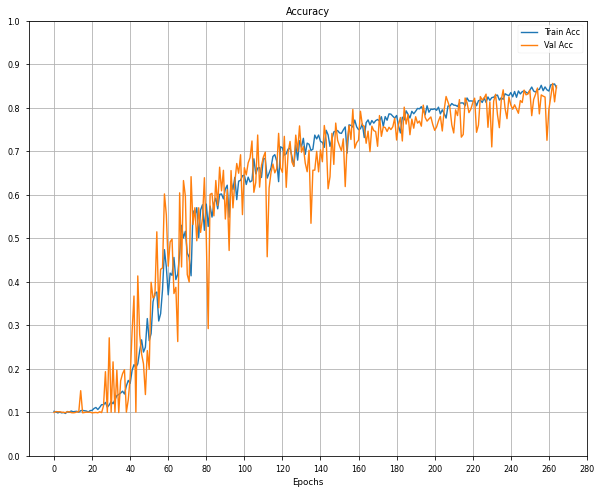

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(Train_A)
plt.plot(Test_A)
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train Acc", "Val Acc"])
plt.yticks(np.arange(0,1.1,0.1))
plt.xticks(np.arange(0,params['Epocas']+20,20))
plt.grid()
plt.savefig("Accuracy_Plot.png",dpi=300,bbox_inches='tight')
plt.show()


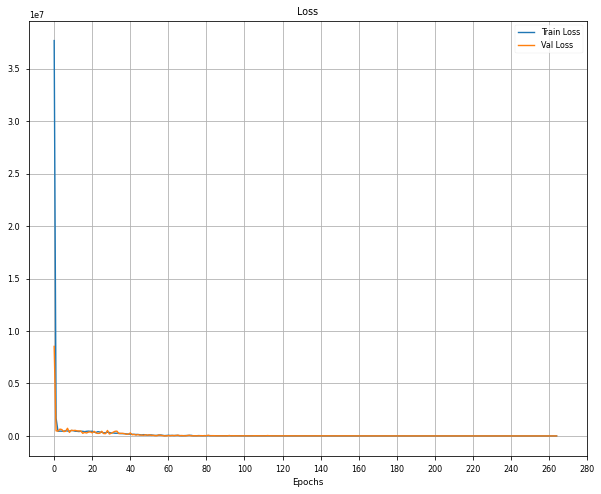

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(Train_L)
plt.plot(Test_L)
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend(["Train Loss", "Val Loss"])

plt.xticks(np.arange(0,params['Epocas']+20,20))
plt.grid()
plt.savefig("Loss_Plot.png",dpi=300,bbox_inches='tight')
plt.show()


Despues de el proceso de entrenamiento, los pesos del modelo podrán usarse para hacer inferencia:

In [ ]:
np.argmax(DNN(np.expand_dims(X[0],axis=0)))

9

El indice 9 representa a la clase 'Ankle Boot'

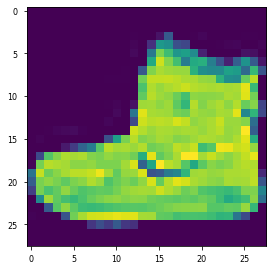

In [ ]:
img0=X[0].reshape((28,28))
plt.imshow(img0)


Para facilitar lo anterior, se puede hacer uso del metodo predict de la clase DNN

## Medidas de Desempeño

A partir del conjunto de datos de prueba medimos la precisión del modelo obtenido.

In [ ]:
batch=x_test
label=DNN.predict(batch)
label.shape

(7000, 10)

In [ ]:
y_test.shape

(7000, 10)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix

score=accuracy_score(y_test,label)

print("Precision de:{}".format(score))

Precision de:0.8572857142857143


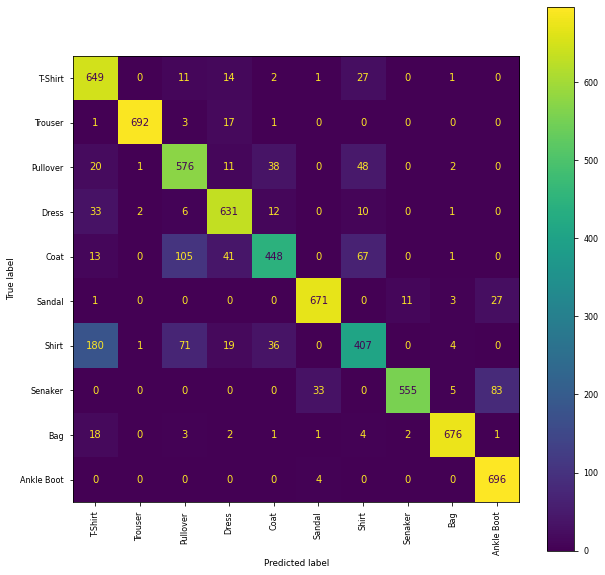

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
figure,ax=plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test,axis=1), 
                                        np.argmax(label,axis=1),
                                        display_labels=["T-Shirt","Trouser",
                                                "Pullover","Dress",
                                                "Coat","Sandal",
                                                "Shirt","Senaker",
                                                "Bag","Ankle Boot"],
                                        xticks_rotation='vertical',
                                        ax=ax)
plt.savefig("CFMatrix_Plot.png",dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
#@title Guardar y Descargar Modelo
import os
model_name='DNN_Final' #@param {type:"string"}

tf.saved_model.save(DNN,model_name)

path='/content/'
zip_file=path+model_name+str('.zip')
dir_to_zip=path+model_name+" "+"*.png"

os.system("zip -r {} {}".format(zip_file,dir_to_zip))


files.download(zip_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# resored=tf.saved_model.load('NN_FullTF')

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [ ]:
!jupyter nbconvert --to pdf /content/MLP_TensorFlowV2.ipynb